In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# create synthetic data

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 128 # usually 2^n to utilise hardware structure
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

Keras manages a global state, which it uses to implement the Functional model-building API and to uniquify autogenerated layer names. If you are creating many models in a loop or in a notebook where the global states are accessible, this global state will consume an increasing amount of memory over time, and you may want to clear it. You do this with:

    
    tf.keras.backend.clear_session()
    

In [4]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)



# Simple RNN

In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), # extend dims creates input_shape = (batch_size, window_size, 1)
                        input_shape=[None]), # no need to define it
    tf.keras.layers.SimpleRNN(40, return_sequences=True), 
    # return sequences needed so that you can feed them into the next layer as inputs
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    # The output layer uses tanh activation function will outputs values between -1 and 1. 
    # To help training, we can scale the output to the same magnitude as the train data so that the loss function can be minimised better. 
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# output_shape = (batch_size, 1)

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
SGDoptimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=SGDoptimizer, metrics=["mae"])

In [6]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 3s 85ms/step - loss: 194.1389 - mae: 194.6682194.1017 - mae: 194.6
Epoch 2/100
31/31 [==============================] - 1s 23ms/step - loss: 188.8949 - mae: 189.3034
Epoch 3/100
31/31 [==============================] - 1s 21ms/step - loss: 182.1074 - mae: 182.5611
Epoch 4/100
31/31 [==============================] - 1s 22ms/step - loss: 174.0349 - mae: 174.6177
Epoch 5/100
31/31 [==============================] - 1s 21ms/step - loss: 164.6217 - mae: 165.0986
Epoch 6/100
31/31 [==============================] - 1s 23ms/step - loss: 152.8124 - mae: 153.3310
Epoch 7/100
31/31 [==============================] - 1s 24ms/step - loss: 137.4112 - mae: 137.9987
Epoch 8/100
31/31 [==============================] - 1s 21ms/step - loss: 116.2218 - mae: 116.8954
Epoch 9/100
31/31 [==============================] - 1s 20ms/step - loss: 87.2612 - mae: 87.8955
Epoch 10/100
31/31 [==============================] - 1s 21ms/step - loss: 49.7115 - mae: 

Text(0, 0.5, 'loss')

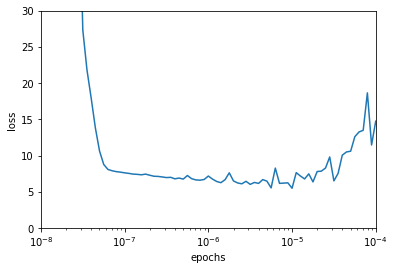

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])
plt.xlabel("Learning Rate")
plt.ylabel("loss")

In [8]:
SGDoptimizer = tf.keras.optimizers.SGD(learning_rate=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=SGDoptimizer, metrics=["mae"])

In [9]:
history = model.fit(train_set,epochs=400)

Epoch 1/400
31/31 [==============================] - 2s 71ms/step - loss: 14.9574 - mae: 15.4397
Epoch 2/400
31/31 [==============================] - 1s 19ms/step - loss: 11.6887 - mae: 12.1639
Epoch 3/400
31/31 [==============================] - 1s 22ms/step - loss: 8.0534 - mae: 8.4867
Epoch 4/400
31/31 [==============================] - 1s 20ms/step - loss: 9.3193 - mae: 9.8120
Epoch 5/400
31/31 [==============================] - 1s 21ms/step - loss: 7.1563 - mae: 7.6629
Epoch 6/400
31/31 [==============================] - 1s 22ms/step - loss: 8.5831 - mae: 9.1040
Epoch 7/400
31/31 [==============================] - 1s 21ms/step - loss: 6.7151 - mae: 7.1996
Epoch 8/400
31/31 [==============================] - 1s 21ms/step - loss: 7.5508 - mae: 7.9750
Epoch 9/400
31/31 [==============================] - 1s 22ms/step - loss: 8.7640 - mae: 9.2504
Epoch 10/400
31/31 [==============================] - 1s 22ms/step - loss: 5.8194 - mae: 6.2688
Epoch 11/400
31/31 [=========================

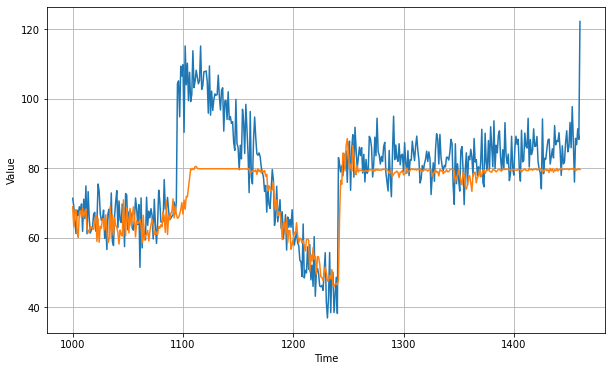

In [10]:
forecast=[]
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

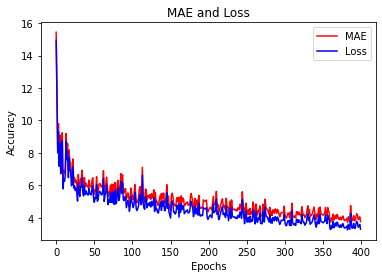

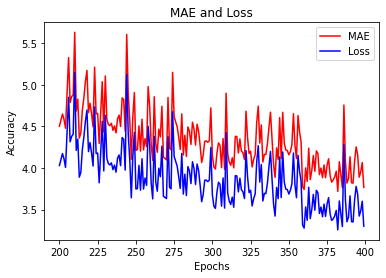

In [11]:
mae = history.history['mae']
loss = history.history['loss']
epochs=range(len(loss))

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

plt.figure()
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

# LSTM

In [12]:
tf.keras.backend.clear_session()

In [13]:
# 2 layer LSTM
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                        input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
SGDoptimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=SGDoptimizer, metrics=["mae"])

In [14]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 8s 272ms/step - loss: 29.5353 - mae: 30.0900
Epoch 2/100
31/31 [==============================] - 1s 16ms/step - loss: 28.6988 - mae: 29.2023
Epoch 3/100
31/31 [==============================] - 0s 15ms/step - loss: 27.6805 - mae: 28.1684
Epoch 4/100
31/31 [==============================] - 0s 14ms/step - loss: 26.6159 - mae: 27.0649
Epoch 5/100
31/31 [==============================] - 0s 13ms/step - loss: 25.4648 - mae: 25.9454
Epoch 6/100
31/31 [==============================] - 0s 13ms/step - loss: 24.2575 - mae: 24.8086
Epoch 7/100
31/31 [==============================] - 0s 13ms/step - loss: 23.1155 - mae: 23.6982
Epoch 8/100
31/31 [==============================] - 0s 13ms/step - loss: 22.1099 - mae: 22.6443
Epoch 9/100
31/31 [==============================] - 0s 14ms/step - loss: 21.1480 - mae: 21.6639
Epoch 10/100
31/31 [==============================] - 0s 13ms/step - loss: 20.1575 - mae: 20.7434
Epoch 11/100
31/31 [========

Text(0, 0.5, 'Loss')

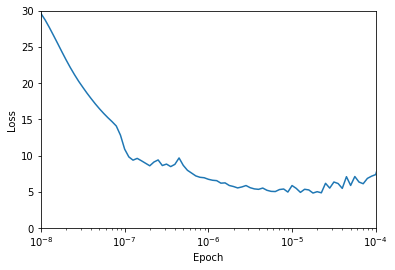

In [15]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")

In [16]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9), metrics=["mae"])

In [17]:
history = model.fit(train_set,epochs=500,verbose=0)

In [18]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

5.8557506

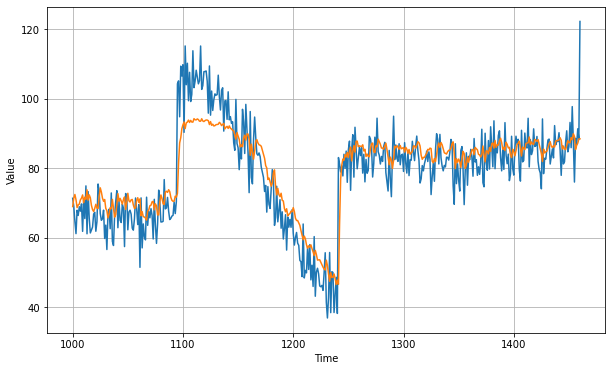

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

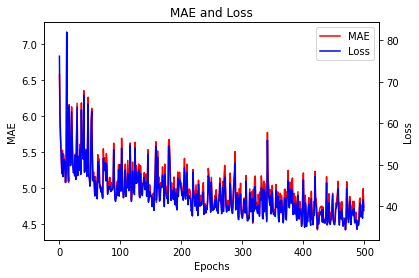

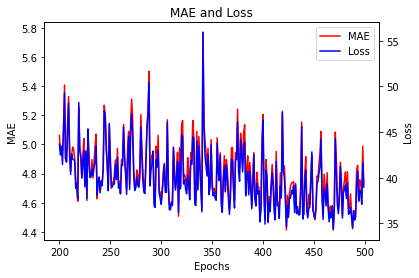

In [31]:
mae = history.history['mae']
loss= history.history['loss']
epochs=range(len(loss))

fig, ax = plt.subplots()
ax2 = ax.twinx()
p1,  = ax.plot(epochs, mae, 'r', label="MAE")
p2,  = ax2.plot(epochs, loss, 'b', label="Loss")
ax.set_title('MAE and Loss')
ax.set_xlabel("Epochs")
ax.set_ylabel("MAE")
ax2.set_ylabel("Loss")
ax.legend(handles=[p1, p2])


epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

fig, ax = plt.subplots()
ax2 = ax.twinx()
p1,  = ax.plot(epochs_zoom, mae_zoom, 'r', label="MAE")
p2,  = ax2.plot(epochs_zoom, loss_zoom, 'b', label="Loss")
ax.set_title('MAE and Loss')
ax.set_xlabel("Epochs")
ax.set_ylabel("MAE")
ax2.set_ylabel("Loss")
ax.legend(handles=[p1, p2])

In [33]:
# 3 layer LSTM
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                        input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
SGDoptimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=SGDoptimizer, metrics=["mae"])


In [34]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
31/31 [==============================] - 9s 275ms/step - loss: 14.5002 - mae: 14.969914
Epoch 2/100
31/31 [==============================] - 1s 16ms/step - loss: 14.3683 - mae: 14.8619
Epoch 3/100
31/31 [==============================] - 0s 16ms/step - loss: 14.3548 - mae: 14.7812
Epoch 4/100
31/31 [==============================] - 0s 15ms/step - loss: 14.2105 - mae: 14.7118
Epoch 5/100
31/31 [==============================] - 0s 15ms/step - loss: 14.1117 - mae: 14.6433
Epoch 6/100
31/31 [==============================] - 0s 15ms/step - loss: 14.0871 - mae: 14.5797
Epoch 7/100
31/31 [==============================] - 0s 15ms/step - loss: 14.0373 - mae: 14.5135
Epoch 8/100
31/31 [==============================] - 0s 15ms/step - loss: 13.9660 - mae: 14.4498
Epoch 9/100
31/31 [==============================] - 0s 15ms/step - loss: 13.8660 - mae: 14.3859
Epoch 10/100
31/31 [==============================] - 0s 15ms/step - loss: 13.7956 - mae: 14.3232
Epoch 11/100
31/31 [======

Text(0, 0.5, 'Loss')

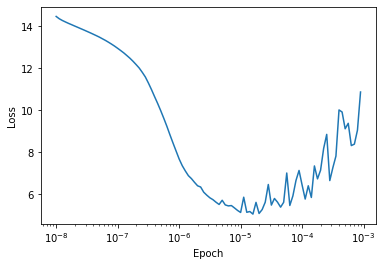

In [39]:
plt.semilogx(history.history["lr"], history.history["loss"])
# plt.axis([1e-8, 1e-4, 0, 30])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")

In [42]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(train_set,epochs=400)

Epoch 1/400
31/31 [==============================] - 8s 256ms/step - loss: 52.9785 5
Epoch 2/400
31/31 [==============================] - 0s 15ms/step - loss: 51.7252
Epoch 3/400
31/31 [==============================] - 0s 15ms/step - loss: 54.3913
Epoch 4/400
31/31 [==============================] - 0s 15ms/step - loss: 51.3689
Epoch 5/400
31/31 [==============================] - 0s 15ms/step - loss: 55.8767
Epoch 6/400
31/31 [==============================] - 0s 15ms/step - loss: 51.8595
Epoch 7/400
31/31 [==============================] - 0s 15ms/step - loss: 53.0413
Epoch 8/400
31/31 [==============================] - 0s 15ms/step - loss: 52.6501
Epoch 9/400
31/31 [==============================] - 0s 15ms/step - loss: 55.5092
Epoch 10/400
31/31 [==============================] - 0s 15ms/step - loss: 52.9003
Epoch 11/400
31/31 [==============================] - 0s 15ms/step - loss: 55.6029
Epoch 12/400
31/31 [==============================] - 0s 15ms/step - loss: 56.7523
Epoch 13/4

6.847345

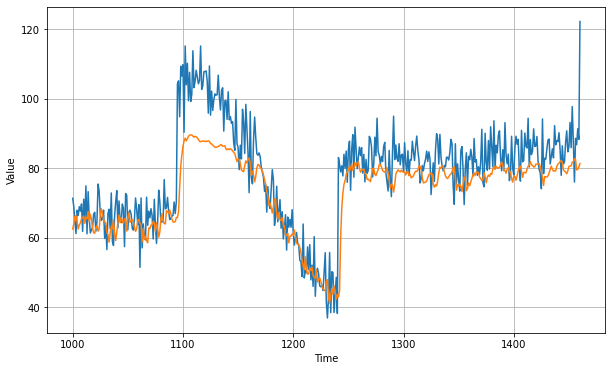

In [43]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

# Conv-LSTM

In [41]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

**Huber loss function**
$$ L_{\delta}(y,\hat{y} ) = \begin{cases} 
      \frac{1}{2}(y-\hat{y})^2 & for \ |y-\hat{y}| \leq \delta \\
      \delta(|y-\hat{y}|-\frac{1}{2}\delta) & otherwise \\
   \end{cases} \ $$
Where $(y-\hat{y})$ is the residual. The function is quadratic for small values and lineat for large values and is less sensitive to outliers and performs better with noisy timeseries. 

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                        strides=1, padding="causal",
                        activation="relu",
                        input_shape=[None, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
SGDoptimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=SGDoptimizer, metrics=["mae"])

In [6]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 11s 1s/step - loss: 61.7317 - mae: 62.2982
Epoch 2/100
8/8 [==============================] - 0s 39ms/step - loss: 59.7316 - mae: 60.2795
Epoch 3/100
8/8 [==============================] - 0s 42ms/step - loss: 54.7659 - mae: 55.3490
Epoch 4/100
8/8 [==============================] - 0s 45ms/step - loss: 47.3513 - mae: 47.9872
Epoch 5/100
8/8 [==============================] - 0s 35ms/step - loss: 43.8417 - mae: 44.3887
Epoch 6/100
8/8 [==============================] - 0s 31ms/step - loss: 41.6690 - mae: 42.2255
Epoch 7/100
8/8 [==============================] - 0s 36ms/step - loss: 39.6998 - mae: 40.2346
Epoch 8/100
8/8 [==============================] - 0s 37ms/step - loss: 37.5892 - mae: 38.1276
Epoch 9/100
8/8 [==============================] - 0s 41ms/step - loss: 35.1018 - mae: 35.7293
Epoch 10/100
8/8 [==============================] - 0s 43ms/step - loss: 32.0876 - mae: 32.6141
Epoch 11/100
8/8 [==============================] 

Text(0, 0.5, 'Loss')

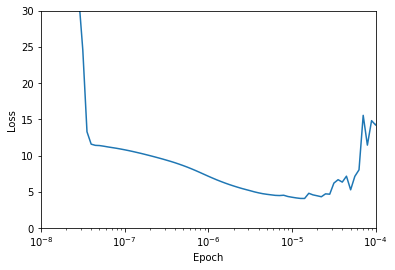

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")

In [42]:
SGDoptimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=SGDoptimizer, metrics=["mae"]) 

In [43]:
history = model.fit(train_set,epochs=500, verbose=0)

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [44]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

10.165531

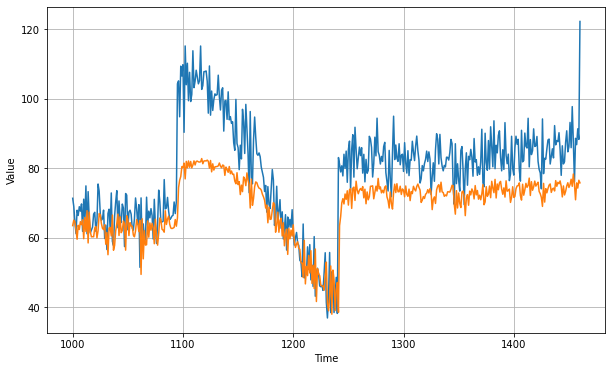

In [45]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

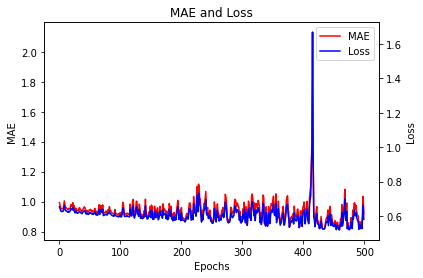

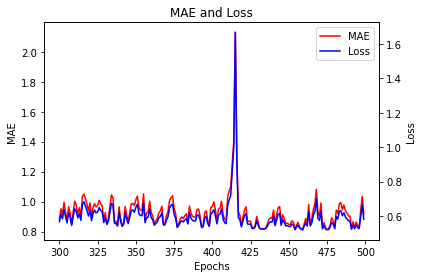

In [49]:
mae = history.history['mae']
loss= history.history['loss']
epochs=range(len(loss))

fig, ax = plt.subplots()
ax2 = ax.twinx()
p1,  = ax.plot(epochs, mae, 'r', label="MAE")
p2,  = ax2.plot(epochs, loss, 'b', label="Loss")
ax.set_title('MAE and Loss')
ax.set_xlabel("Epochs")
ax.set_ylabel("MAE")
ax2.set_ylabel("Loss")
ax.legend(handles=[p1, p2])


epochs_zoom = epochs[300:]
mae_zoom = mae[300:]
loss_zoom = loss[300:]

fig, ax = plt.subplots()
ax2 = ax.twinx()
p1,  = ax.plot(epochs_zoom, mae_zoom, 'r', label="MAE")
p2,  = ax2.plot(epochs_zoom, loss_zoom, 'b', label="Loss")
ax.set_title('MAE and Loss')
ax.set_xlabel("Epochs")
ax.set_ylabel("MAE")
ax2.set_ylabel("Loss")
ax.legend(handles=[p1, p2])

# this shows that we could have stopped training after 250 epochs because the loss is barely going down